# Summary

In this notebook, our goal is to perform time series analysis to identify fraud patterns.

The details are listed as following:

- Analyze temporal patterns in fraudulent transactions
- Create moving averages and identify seasonal trends
- Develop statistical measures for anomaly detection
- Implement SQL window functions for time-based analysis
- Visualize patterns and create interpretable reports

Data source:
https://www.kaggle.com/c/ieee-fraud-detection/data

Coding environment:
Google colab, Python 3 + CPU

Note:
This data is too large to perform operations with normal pandas operations, so I choose pyspark for this task.

Key assumption(s):
1. The smallest unit of time delta is second.

## packages and dependencies

In [1]:
!pip install kaggle

In [2]:
import os

# Create the .kaggle directory
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Move kaggle.json to the .kaggle directory
!mv kaggle.json /root/.config/kaggle/

In [3]:
# security concern on API key
!chmod 600 /root/.config/kaggle/kaggle.json

In [4]:
import numpy as np
import pandas as pd

import kaggle

import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

## dataset

In [ ]:
# !kaggle datasets download -d c/ieee-fraud-detection
# idk why we caused a 403. but as we can download it from the webpage, I uploaded it here for further use

In [5]:
with zipfile.ZipFile("ieee-fraud-detection.zip", 'r') as zip_ref:
    # Extract to a folder named "data"
    zip_ref.extractall("data")

In [6]:
# Initialize SparkSession
spark = SparkSession.builder.appName("Time Series Analysis").getOrCreate()

In [7]:
# we use train dataset for our analysis
df_trans = spark.read.csv("data/train_transaction.csv", header=True, inferSchema=True)

In [8]:
df_id = spark.read.csv("data/train_identity.csv", header=True, inferSchema=True)

In [9]:
# combine two dataframe
# as not all transactions have corresponding identity information, we would like to preserve all info in df_trans
df = df_trans.join(df_id, df_trans["TransactionID"] == df_id["TransactionID"], "left")

# remove duplicate columns
df = df.drop(df_id["TransactionID"])

In [10]:
df.printSchema()

root
 |-- TransactionID: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- TransactionDT: integer (nullable = true)
 |-- TransactionAmt: double (nullable = true)
 |-- ProductCD: string (nullable = true)
 |-- card1: integer (nullable = true)
 |-- card2: double (nullable = true)
 |-- card3: double (nullable = true)
 |-- card4: string (nullable = true)
 |-- card5: double (nullable = true)
 |-- card6: string (nullable = true)
 |-- addr1: double (nullable = true)
 |-- addr2: double (nullable = true)
 |-- dist1: double (nullable = true)
 |-- dist2: double (nullable = true)
 |-- P_emaildomain: string (nullable = true)
 |-- R_emaildomain: string (nullable = true)
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: double (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable = true)
 |-- C9: double (nullable = true)
 |-- C10:

In [11]:
df.show(10)

+-------------+-------+-------------+--------------+---------+-----+-----+-----+----------+-----+------+-----+-----+-----+-----+-------------+-------------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+-----+-----+----+-----+----+----+----+------+-----+----+-----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+------+-----+----+-----+-----+-

## temporal patterns

In [12]:
# check data balance
# df['isFraud'].value_counts()

# Count the occurrences of each value in the "isFraud" column
fraud_counts = df.groupBy("isFraud").count()

# Show the results
fraud_counts.show()

+-------+------+
|isFraud| count|
+-------+------+
|      1| 20663|
|      0|569877|
+-------+------+



In [13]:
# to simplify the analysis, we only care about the columns with exact meanings to us
cols_cate = [
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType',
 'DeviceInfo'
]

cols_num = [
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2',
]

### categorical columns analysis

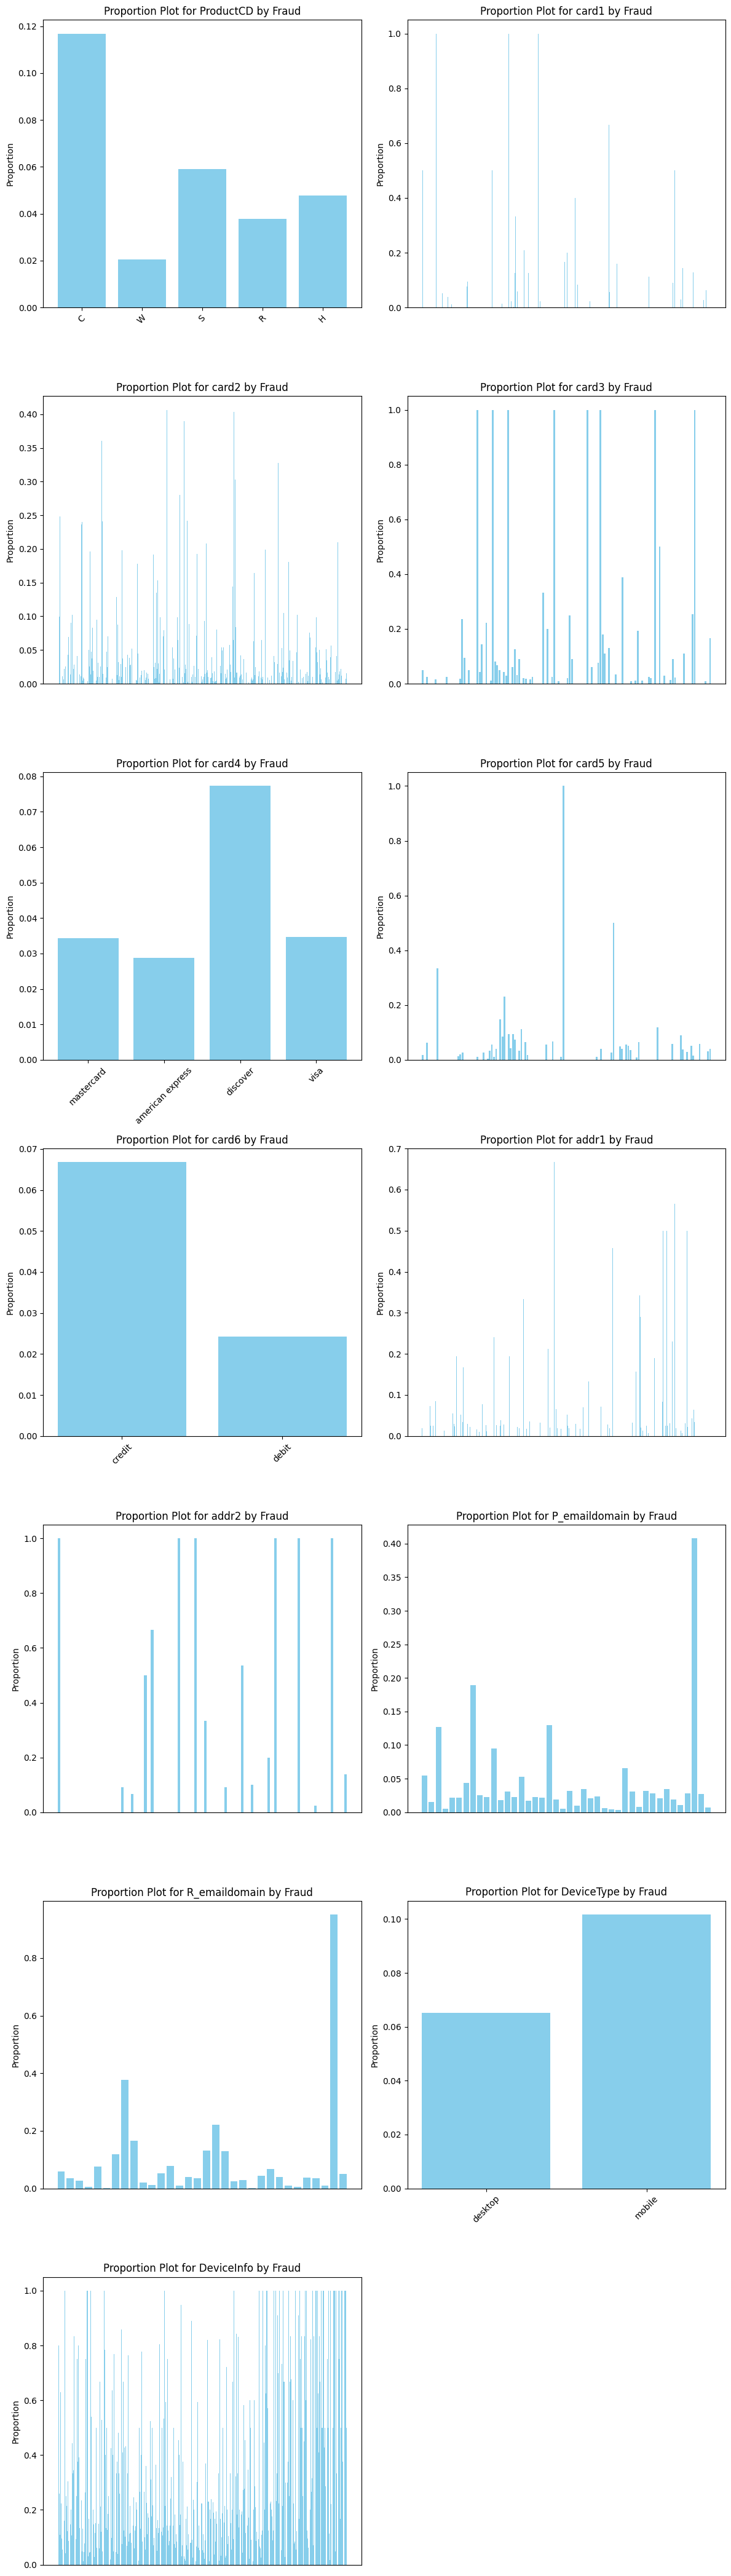

In [14]:
# Define the number of columns in the grid
num_cols = 2  # For 2 columns in the grid
num_rows = len(cols_cate) // num_cols + (len(cols_cate) % num_cols > 0)
# num_rows = (len(cols_cate) + num_cols - 1) // len(cols_cate)

# Create a figure and axis for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array to easily loop through
axes = axes.flatten()

for i, col_name in enumerate(cols_cate):
    # Group by the column and 'isFraud', then count occurrences
    grouped_df = df.filter(df['isFraud'] == 1).groupBy(col_name).agg(F.count(F.lit(1)).alias("count"))

    # Calculate proportions
    total_counts = df.groupBy(col_name).agg(F.count(F.lit(1)).alias("total"))
    proportions_df = grouped_df.join(total_counts, col_name).withColumn(
        "proportion", F.col("count") / F.col("total")
    )

    # Convert to Pandas for plotting
    pandas_df = proportions_df.toPandas()

    axes[i].bar(pandas_df[col_name], pandas_df['proportion'], color='skyblue')

    # hide the xaxis if it's too long
    if pandas_df[col_name].nunique() > 15:
        # If conditions met, remove x-axis labels
        axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
        # Otherwise, show x-axis labels
        axes[i].set_xticks(pandas_df[col_name].unique())  # Show all unique values as ticks
        axes[i].set_xticklabels(pandas_df[col_name].unique(), rotation=45)  # Optionally rotate the labels for better readability


    # Customize the plot for each subplot
    axes[i].set_ylabel("Proportion")
    axes[i].set_title(f"Proportion Plot for {col_name} by Fraud")


# Remove any unused axes
for ax in axes[len(cols_cate):]:
    fig.delaxes(ax)  # Remove extra axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plots
plt.show()

We could see clearly from the plot above that there would be explicit indicators in card 1, card 2, card 5, addr2, DeviceInfo, etc, showing the transaction is highly probable to be a fraud. Credit cards are more likely than other cards to fall into fraud while mobile transactions are more likely to desktop transactions.

### numerical columns analysis

In [15]:
max_transaction_dt = df.agg(F.max("TransactionDT")).collect()[0][0]

print(f"Maximum TransactionDT: {max_transaction_dt}")

Maximum TransactionDT: 15811131


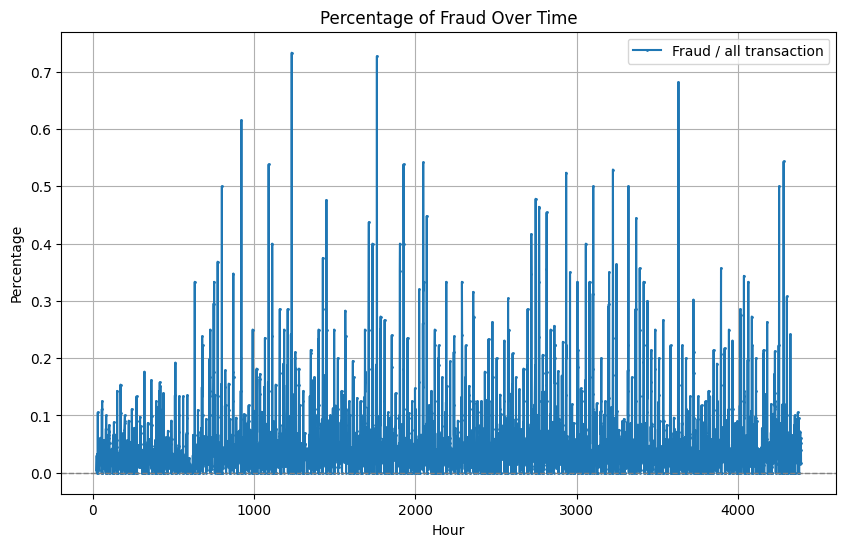

In [16]:
# I used to use the following code for data manipulation
# then convert it to SQL equivalent in pyspark

# # Add 'hour' column
# df = df.withColumn("hour", (F.col("TransactionDT") / (60 * 60)).cast('int'))

# # Group by "hour" and "isFraud", count "TransactionID"
# agg = (
#     df.groupBy("hour", "isFraud")
#     .agg(F.count("TransactionID").alias("count"))
# )

# # Step 3: Pivot to create a table with fraud and not-fraud counts
# pivot = (
#     agg.groupBy("hour")
#     .pivot("isFraud", values=[0, 1])  # 0: Not Fraud, 1: Fraud
#     .sum("count")
#     .fillna(0)
#     .withColumnRenamed("0", "not_fraud")
#     .withColumnRenamed("1", "fraud")
# )

# # Calculate percentage of fraud
# pivot = pivot.withColumn(
#     "percentage", F.col("fraud") / (F.col("fraud") + F.col("not_fraud"))
# )

# Register the DataFrame as a temporary view
df.createOrReplaceTempView("transactions")

# Add 'hour' column using SQL
spark.sql("""
    CREATE OR REPLACE TEMP VIEW transactions_with_hour AS
    SELECT *, CAST(TransactionDT / (60 * 60) AS INT) AS hour
    FROM transactions
""")

# Group by "hour" and "isFraud", count "TransactionID"
spark.sql("""
    CREATE OR REPLACE TEMP VIEW agg AS
    SELECT
        hour,
        isFraud,
        COUNT(TransactionID) AS count
    FROM transactions_with_hour
    GROUP BY hour, isFraud
""")

# Pivot the data to separate fraud and not-fraud counts
spark.sql("""
    CREATE OR REPLACE TEMP VIEW pivot AS
    SELECT
        hour,
        COALESCE(SUM(CASE WHEN isFraud = 0 THEN count ELSE 0 END), 0) AS not_fraud,
        COALESCE(SUM(CASE WHEN isFraud = 1 THEN count ELSE 0 END), 0) AS fraud
    FROM agg
    GROUP BY hour
""")

# Calculate the percentage of fraud
final_df = spark.sql("""
    SELECT
        hour,
        not_fraud,
        fraud,
        fraud / (fraud + not_fraud) AS percentage
    FROM pivot
""")



# Convert to Pandas DataFrame for plotting
pandas_pivot = final_df.toPandas()
pandas_pivot.sort_values(by='hour', ascending=True, inplace=True)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pandas_pivot["hour"], pandas_pivot["percentage"], marker="o", markersize = 1, label="Fraud / all transaction")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Percentage of Fraud Over Time")
plt.xlabel("Hour")
plt.ylabel("Percentage")
plt.legend()
plt.grid(True)
plt.show()


Through the chart above we can see clearly that there would be time intervals with high probable frauds to pay attention to.

In [17]:
def hist_plot(df, col, bin_width = 25, xmax = 1500):
  # Bin the column
  df = df.withColumn("bin", (F.col(col) / bin_width + 1.0).cast("int") * bin_width)

  # Group by bins and isFraud to count occurrences
  grouped_df = df.groupBy("bin", "isFraud").count()

  # Pivot the data to create separate columns for fraud and not-fraud counts
  pivot_df = grouped_df.groupBy("bin").pivot("isFraud", values=[0, 1]).sum("count").fillna(0)
  pivot_df = pivot_df.withColumnRenamed("0", "not_fraud").withColumnRenamed("1", "fraud")

  # Convert to Pandas for plotting
  pandas_df = pivot_df.orderBy("bin").toPandas()
  pandas_df = pandas_df.rename(columns={"not_fraud": 0, "fraud": 1})

  # Plot stacked histogram
  plt.bar(pandas_df["bin"], pandas_df[0], color="blue", label="Not Fraud", width=bin_width, align="edge")
  plt.bar(pandas_df["bin"], pandas_df[1], bottom=pandas_df[0], color="red", label="Fraud", width=bin_width, align="edge")
  plt.xlabel(col)
  plt.ylabel("Count")
  plt.title("Histogram of {} by Fraud".format(col))
  plt.legend()
  plt.grid(True, alpha=0.3)

  # Limit x-axis scope
  plt.xlim(0, xmax)

  plt.show()

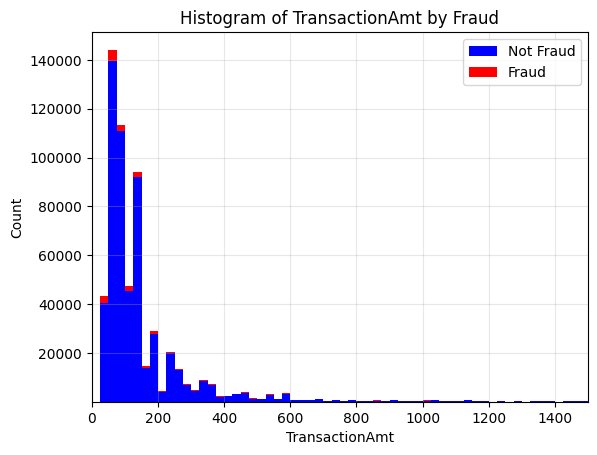

In [18]:
# TransactionAmt: most are under 1000
# sns.histplot(df, x="TransactionAmt", hue="isFraud", bins=25, multiple="stack", palette="Set1")

hist_plot(df, "TransactionAmt")

In [19]:
# to get scope of transaction amount

max_transaction_amt = df.agg(F.max("TransactionAmt")).collect()[0][0]

print(f"Maximum TransactionAmt: {max_transaction_amt}")

Maximum TransactionAmt: 31937.391


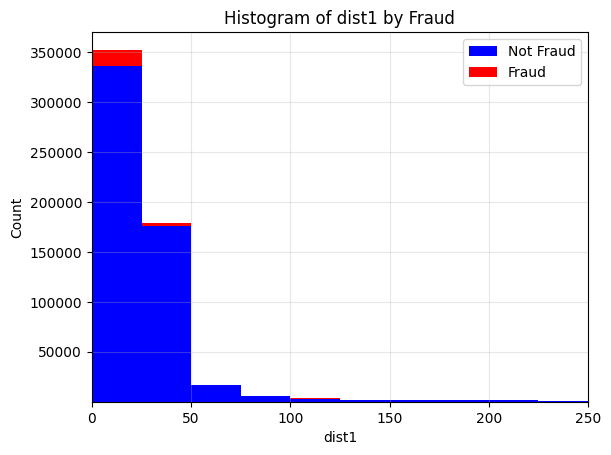

In [20]:
# sns.histplot(df, x="dist1", hue="isFraud", bins=25, multiple="stack", palette="Set1")

# Bin the dist1 column
hist_plot(df, "dist1", xmax = 250)

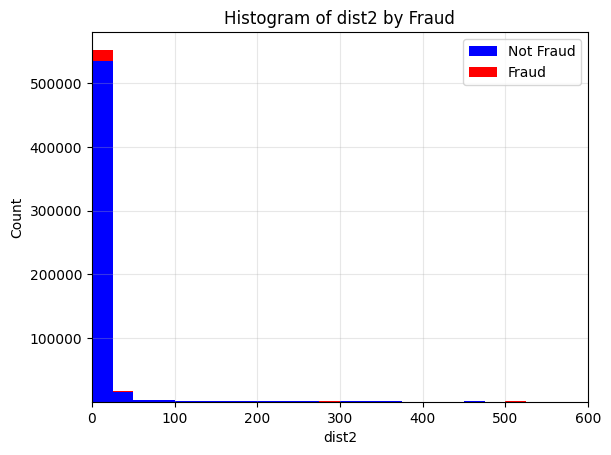

In [21]:
# dist2 shows more centralized info about fraud
# sns.histplot(df, x="dist2", hue="isFraud", bins=25, multiple="stack", palette="Set1")

hist_plot(df, 'dist2', xmax = 600)

In [22]:

non_null_count = df.filter(F.col("dist1").isNotNull() & F.col("dist2").isNotNull()).count()

print(f"Number of rows with both dist1 and dist2 non-null: {non_null_count}")

Number of rows with both dist1 and dist2 non-null: 0


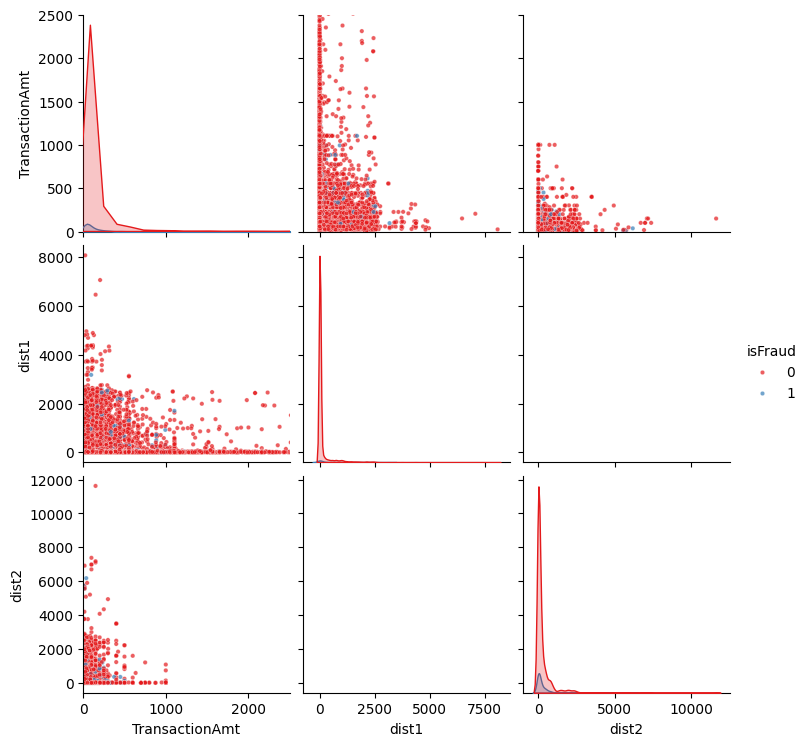

In [23]:
# Sampling and pair plot for relationships between the three

pandas_df = df.select("dist1", "dist2", "TransactionAmt", "isFraud").toPandas()

# Sample data to a manageable size for plotting
pandas_df = pandas_df.sample(frac=0.2, random_state=42)  # 10% of the data

# Create the pairplot
pairplot = sns.pairplot(
    pandas_df,
    vars=["TransactionAmt", "dist1", "dist2"],
    hue="isFraud",
    palette="Set1",
    diag_kind="kde",
    plot_kws={"s": 10, "alpha": 0.7}
    )


# Set axis limits for TransactionAmt
for ax in pairplot.axes.flatten():
    if ax.get_xlabel() == "TransactionAmt":
        ax.set_xlim(0, 2500)  # Set x-axis limit
    if ax.get_ylabel() == "TransactionAmt":
        ax.set_ylim(0, 2500)  # Set y-axis limit

# Show the plot
plt.show()

# pandas_df.head()

## moving average & seasonal trends

According to our prior result about percentage of fraud over time, we can safely assume there exists seasonal trends.

We will further explore it below.

In [24]:
# we can use the aggregate result for percentage of fraud over time for this analysis
time_series = pandas_pivot

### percentage

In [25]:
time_series.head()

,hour,not_fraud,fraud,percentage
2974,24,227,1,0.004386
2913,25,195,6,0.029851
436,26,180,0,0.000000
438,27,131,3,0.022388
316,28,89,3,0.032609


In [26]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4368 entries, 2974 to 81
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hour        4368 non-null   int32  
 1   not_fraud   4368 non-null   int64  
 2   fraud       4368 non-null   int64  
 3   percentage  4368 non-null   float64
dtypes: float64(1), int32(1), int64(2)
memory usage: 153.6 KB


From the info above, we could see that the dataframe aggregated by hour is not large (4,368 entries). As a result, I choose normal pandas operation to avoid reductant code and operations.

In [27]:
time_series['day'] = time_series['hour'] / 24
time_series['week'] = time_series['day'] / 7
time_series['month'] = time_series['day'] / 30

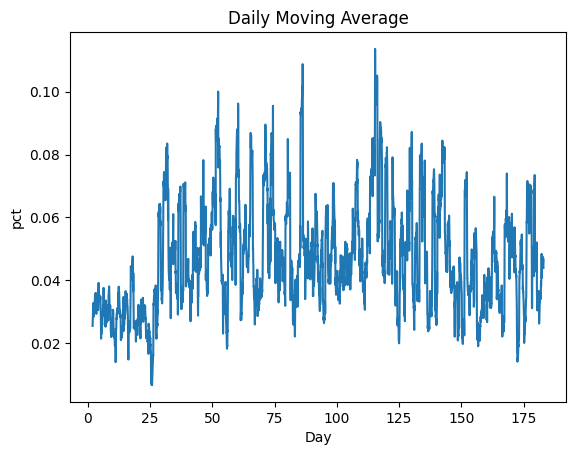

In [28]:
time_series['daily_ma'] = time_series['percentage'].rolling(window=24).mean()

plt.plot(time_series['day'], time_series['daily_ma'], label="Daily Moving Average")
plt.title("Daily Moving Average")
plt.xlabel("Day")
plt.ylabel("pct")
plt.show()

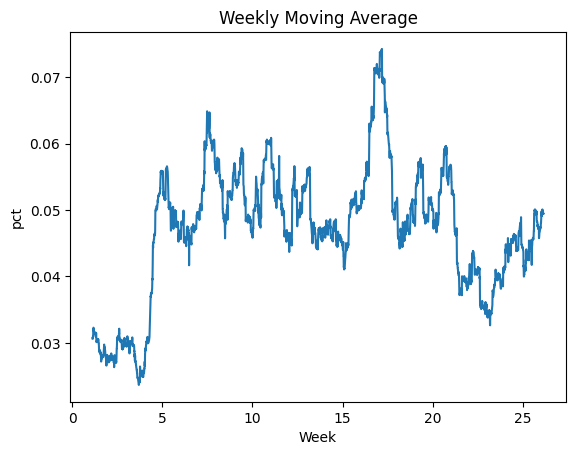

In [29]:
time_series['weekly_ma'] = time_series['percentage'].rolling(window = 24 * 7).mean()

plt.plot(time_series['week'], time_series['weekly_ma'], label="Weekly Moving Average")
plt.title("Weekly Moving Average")
plt.xlabel("Week")
plt.ylabel("pct")
plt.show()

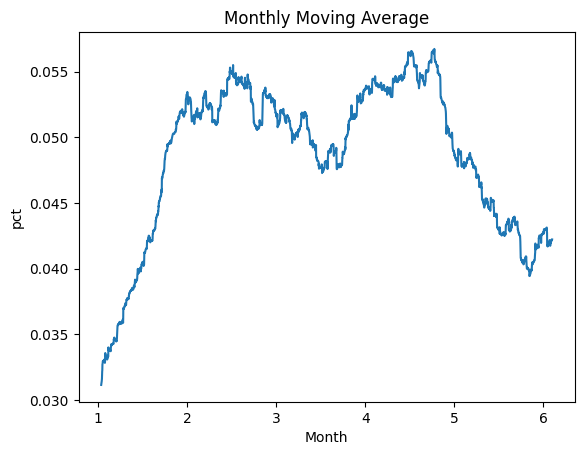

In [30]:
time_series['monthly_ma'] = time_series['percentage'].rolling(window = 24 * 30).mean()

plt.plot(time_series['month'], time_series['monthly_ma'], label="Monthly Moving Average")
plt.title("Monthly Moving Average")
plt.xlabel("Month")
plt.ylabel("pct")
plt.show()

### absolute value

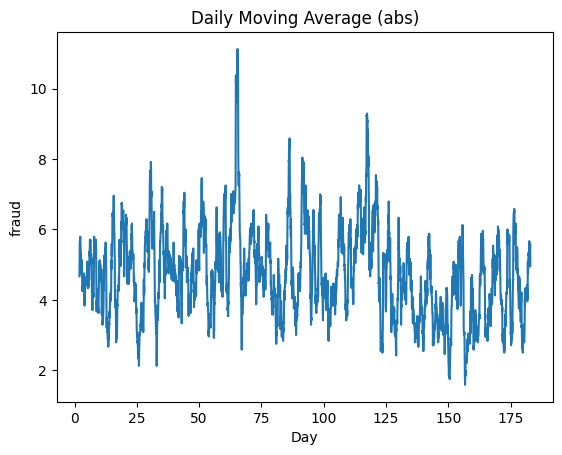

In [31]:
time_series['daily_ma_abs'] = time_series['fraud'].rolling(window=24).mean()

plt.plot(time_series['day'], time_series['daily_ma_abs'], label="Daily Moving Average")
plt.title("Daily Moving Average (abs)")
plt.xlabel("Day")
plt.ylabel("fraud")
plt.show()

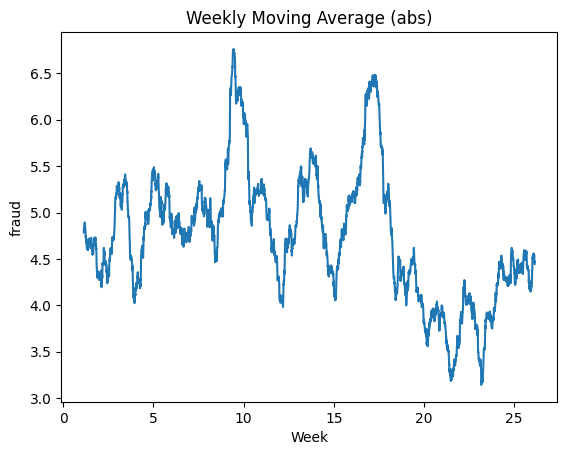

In [32]:
time_series['weekly_ma_abs'] = time_series['fraud'].rolling(window=24 * 7).mean()

plt.plot(time_series['week'], time_series['weekly_ma_abs'], label="Weekly Moving Average")
plt.title("Weekly Moving Average (abs)")
plt.xlabel("Week")
plt.ylabel("fraud")
plt.show()

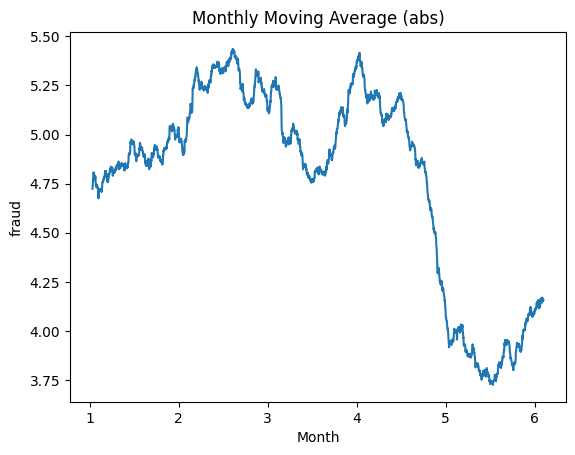

In [33]:
time_series['monthly_ma_abs'] = time_series['fraud'].rolling(window=24 * 30).mean()

plt.plot(time_series['month'], time_series['monthly_ma_abs'], label="Monthly Moving Average")
plt.title("Monthly Moving Average (abs)")
plt.xlabel("Month")
plt.ylabel("fraud")
plt.show()

### analysis

The result of weekly moving average shows clear seasonal patterns with a cycle of 2-3 weeks. A not verified suppose is that it is related to the performance settlement of victims or spam groups.

Both the chart based on percentage and the chart based on the average value show fluctuations on the overall activities.

No clear upward/declining seasonality shown in these charts. It's shown as slightly declining but we need more data to analyze the overall trends.

More information about potential events/factors could be gained with exact time stamp instead of time delta.

## statistical measures for anomaly detection

We conduct anomaly detection on numerical columns.

### z-score calculation

In [34]:
# Calculate mean and standard deviation for the given column
def mean_std_cal(df, col):
  stats = df.select(
      F.mean(col).alias("mean_amount"),
      F.stddev(col).alias("std_amount")
  ).collect()

  mean_amount = stats[0]["mean_amount"]
  std_amount = stats[0]["std_amount"]

  # Add z-score column
  df = df.withColumn(
      "z_score",
      (F.col(col) - F.lit(mean_amount)) / F.lit(std_amount)
  )

  # Flag anomalies where z_score > 3 or z_score < -3
  df = df.withColumn(
      "is_anomaly_z",
      F.abs(F.col("z_score")) > 3
  )

  # Show the results
  pandas_df = df.select("TransactionID", col, "z_score", "is_anomaly_z", "isFraud").toPandas()

  return (mean_amount, std_amount, pandas_df)

In [35]:
# cal intermediate df for TransactionAmt
mean_amount, std_amount, pandas_df = mean_std_cal(df, "TransactionAmt")
print(mean_amount, std_amount)
standard = mean_amount + 3 * std_amount

135.02717637240136 239.16252201373396


In [36]:
def scatter_zscore(pandas_df, isFraud, col, standard):
  title = 'Fraud Credit Card Transactions with Anomalies (Z-Score Method)'
  if(not isFraud):
    title = "Non-" + title
  # Plot the results
  plt.figure(figsize=(10, 6))
  # colors = pandas_df['isFraud'].map({0: 'white', 1: 'red'})
  pdf = pandas_df[pandas_df['isFraud'] == isFraud]

  plt.scatter(pdf["TransactionID"], pdf[col], s = 3)
  plt.axhline(y=standard, color='green', linestyle='--', linewidth=1, label=f'y = {standard}')
  plt.title(title)
  plt.xlabel('Transaction ID')
  plt.ylabel(col)
  plt.legend()
  plt.show()


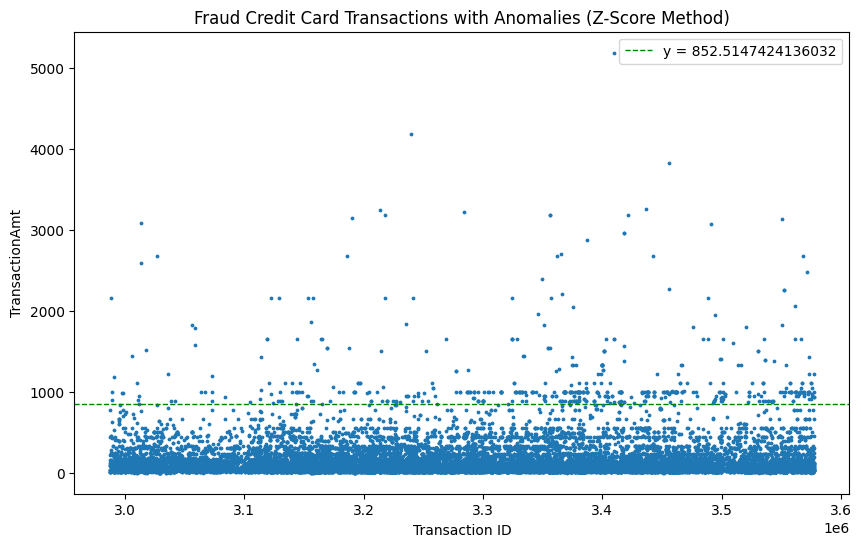

In [37]:
# # Plot the results
scatter_zscore(pandas_df, 1, "TransactionAmt", standard)

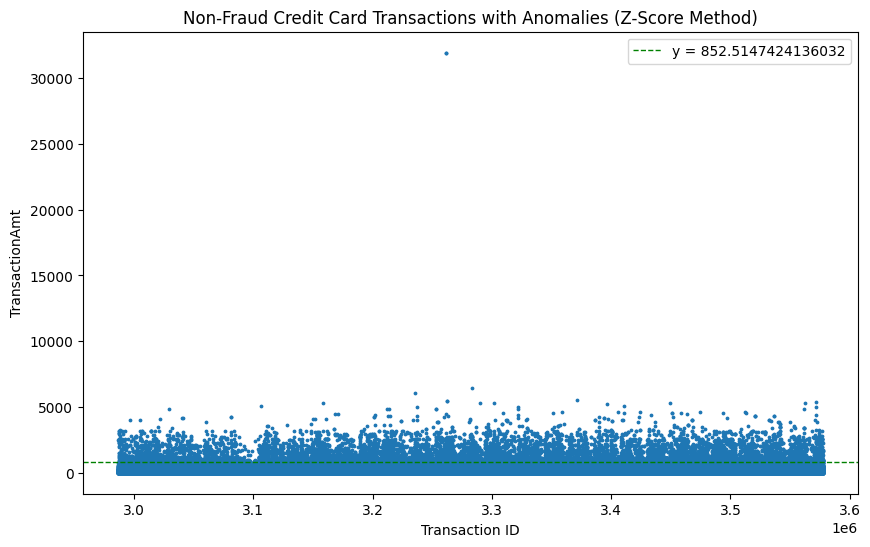

In [38]:
# # Plot the results
scatter_zscore(pandas_df, 0, "TransactionAmt", standard)

Any transaction with a z-score greater than 3 or less than -3 is considered anomalous. Here, as the mean is smaller than the standard deviation, and the minimal transaction amount should be no smaller than 0, we don't take z-score smaller than -3 into consideration.

In the dataset, the high transaction amount (higher than 852.51) would be considered as a anomaly because it deviates significantly from the mean of the other transaction amounts.

By comparing the distribution of transaction amounts between fraud/non-fraud, we can't see a clear difference in fraud and non-fraud indicators with z-score.

In [39]:
# for dist1
mean_amount, std_amount, pandas_df = mean_std_cal(df, "dist1")
print(mean_amount, std_amount)
standard = mean_amount + 3 * std_amount


118.50218030881064 371.8720264911682


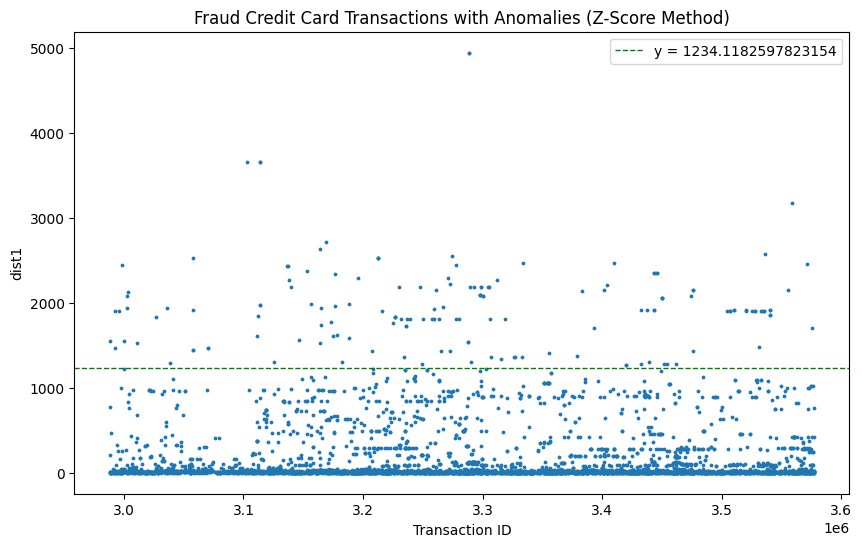

In [40]:
scatter_zscore(pandas_df, 1, 'dist1', standard)

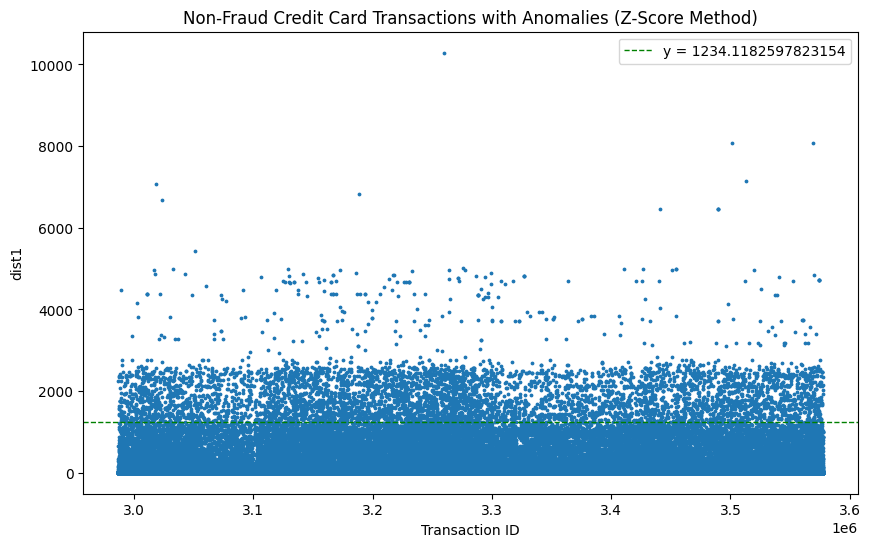

In [41]:
scatter_zscore(pandas_df, 0, 'dist1', standard)

In [42]:
# for dist2
mean_amount, std_amount, pandas_df = mean_std_cal(df, "dist2")
print(mean_amount, std_amount)
standard = mean_amount + 3 * std_amount

231.85542296754988 529.0534935529506


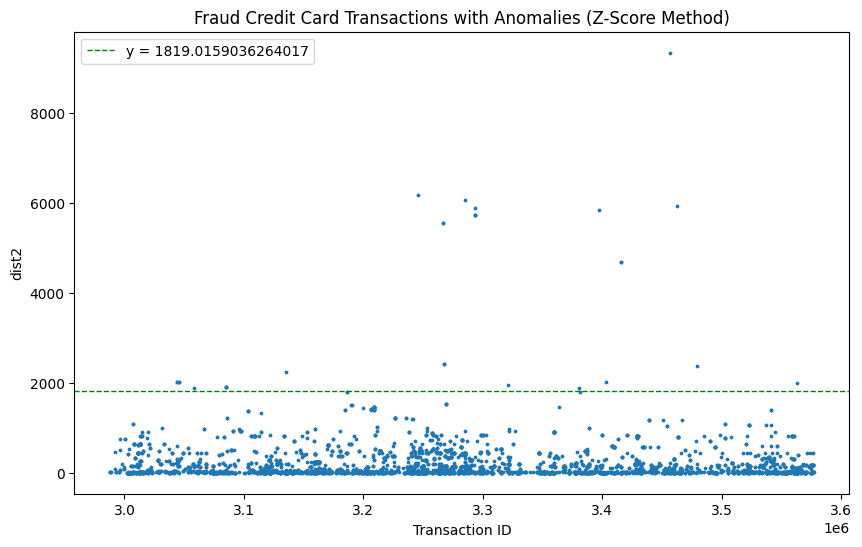

In [43]:
scatter_zscore(pandas_df, 1, 'dist2', standard)

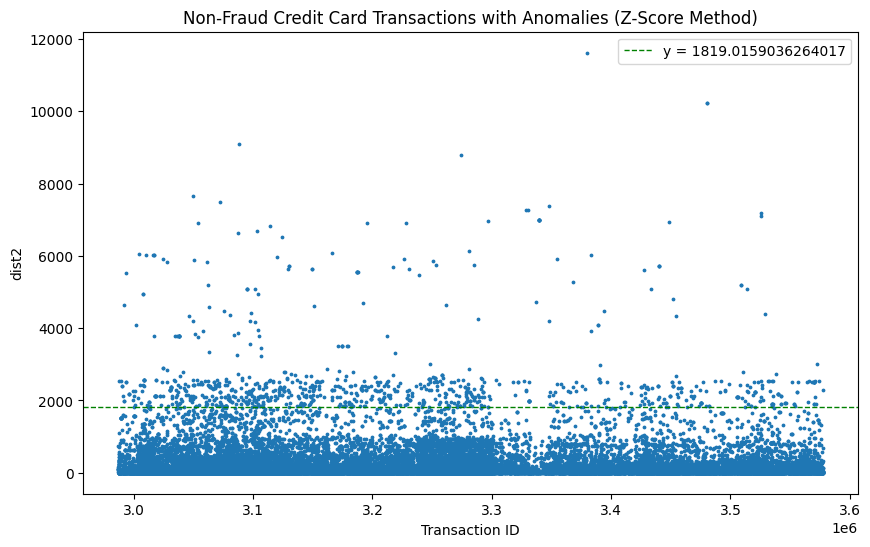

In [44]:
scatter_zscore(pandas_df, 0, 'dist2', standard)

Frauds for dist2 distribute more in non-anomaly data points.

### IQR calculation & sampling visualization

In [45]:
def IQR_analysis(df, col):
  # Calculate Q1 (25th percentile) and Q3 (75th percentile)
  percentiles = df.approxQuantile(col, [0.25, 0.75], 0.0)
  Q1, Q3 = percentiles[0], percentiles[1]

  # Calculate IQR
  IQR = Q3 - Q1

  # Define lower and upper bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Flag anomalies where TransactionAmount is outside the bounds
  df = df.withColumn(
      "is_anomaly_iqr",
      (F.col(col) < F.lit(lower_bound)) | (F.col(col) > F.lit(upper_bound))
  )

  pandas_df = df.select("TransactionID", col, "isFraud", "is_anomaly_iqr").toPandas()

  # Sample data to a manageable size for plotting
  pandas_df = pandas_df.sample(frac=0.2, random_state=42)

  # Plot the results
  plt.figure(figsize=(10, 6))
  colors = pandas_df['isFraud'].map({0: 'blue', 1: 'red'})

  plt.scatter(pandas_df["TransactionID"], pandas_df[col], c = colors, s = 1)
  plt.axhline(y=upper_bound, color='green', linestyle='--', linewidth=1, label=f'y = {upper_bound}')
  # add lower bound if lower_bound > 0
  if(lower_bound > 0):
    plt.axhline(y=lower_bound, color='green', linestyle='--', linewidth=1, label=f'y = {lower_bound}')
  plt.title('Credit Card Transactions with Anomalies (IQR Method)')
  plt.xlabel('Transaction ID')
  plt.ylabel(col)
  plt.legend()
  plt.show()

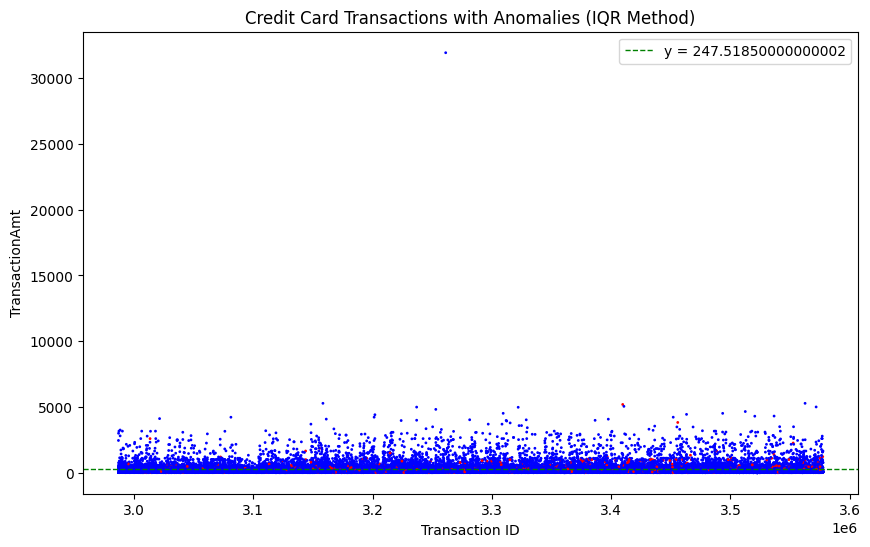

In [46]:
IQR_analysis(df, "TransactionAmt")

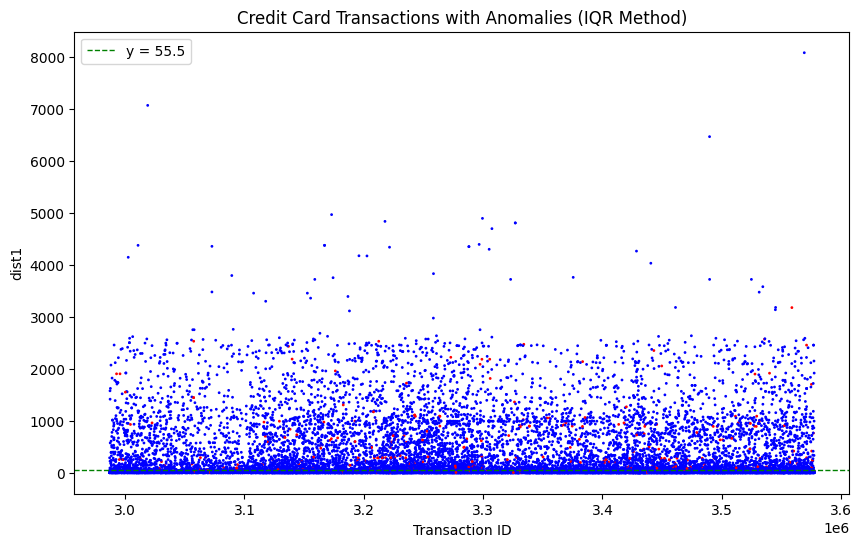

In [47]:
IQR_analysis(df, 'dist1')

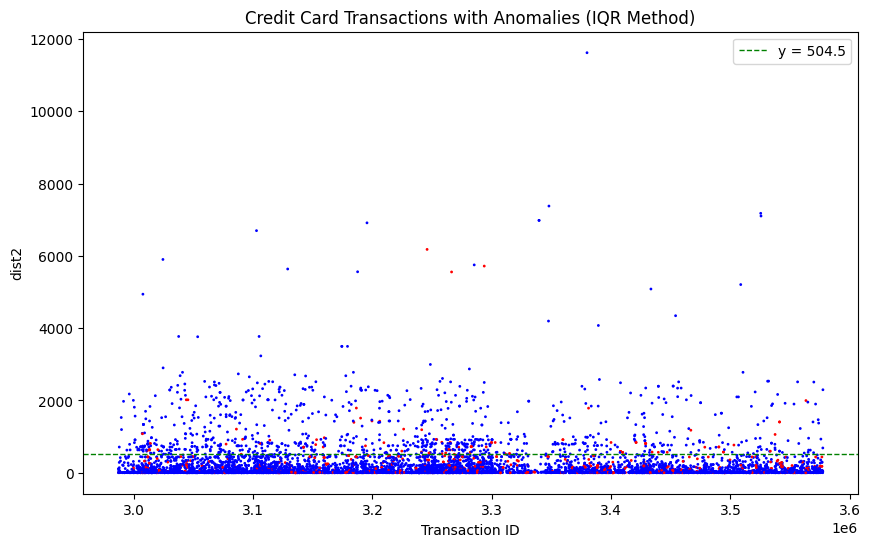

In [48]:
IQR_analysis(df, 'dist2')

From the above visualizations, we could see that fraud in both transaction amount and dist1 have a tendency to distribute above the upper bound, while dist2 shows the more frequency below the upper bound.

Note that the visualization is based on a random sample of the overall data. The real distribution may differ.

## stop spark session ending the POC

In [49]:
spark.stop()